In [5]:
# import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid # to generate unique image names

# import tensorflow dependencies - Functional API. passing through 2 images at same time and measure the similarity. if similar = 1, if diff = 0
from tensorflow.keras.models import Model #
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [13]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# setup paths
POS_PATH = os.path.join('data', 'positive') #joins dif directories together to be able to form a full file path. positive verification images
NEG_PATH = os.path.join('data', 'negative') #negative verification image
ANC_PATH = os.path.join('data', 'anchor')
#make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [8]:
# http://vis-www.cs.umass.edu/lfw/

# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3c91e646-e733-11ec-b224-f0d5bfaceaa8.jpg'

In [229]:
# establish connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

     #cut down from to 250x250px
    frame = frame[120:120 +250,200:200 +250, :]
    # specifying range of values we want from our pic - we want 250x250 to be the same as lfw
    # plt.imshow(frame[120:120 +250,200:200 +250, :])
    # plt.show()


    # collect anchors - if hit a will take anchor image
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)

    # collect positives - if hit p will collect positive image
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out positive image
        cv2.imwrite(imgname, frame)

    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # breaking gracefully - when hit q will close down frame
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# release webcam
cap.release()
# close image show frame
cv2.destroyAllWindows()


In [10]:
# grabbing everything inside paths with.jpg on the end - only want 300 images for each
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [11]:
ANC_PATH+'\*.jpg'

'data\\anchor\\*.jpg'

In [12]:
dir_test = anchor.as_numpy_iterator()

In [21]:
print(dir_test.next())

b'data\\anchor\\6ac93229-e338-11ec-accb-f0d5bfaceaa8.jpg'


In [13]:
# loads image from file path, decode jpg, resize image, scales it
def preprocess(file_path):
    
    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # preprocessing steps - resizing the image to be 100x100px
    img = tf.image.resize(img, (100,100))
    # scale image to be between 0 and 1 - takes every pixel value which is usually from 0-255 and divides it to be between 0 and 1. 
    img = img / 255.0
    
    # Return image
    return img

In [14]:
img = preprocess('data\\anchor\\60c257fd-e338-11ec-a7d0-f0d5bfaceaa8.jpg')

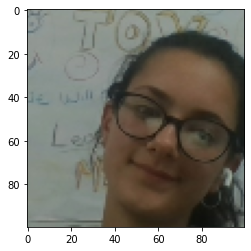

In [194]:
plt.imshow(img)

In [ ]:
dataset.map(preprocess)

In [15]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

# Zip allows us to iterate through all 3 at same time.  tf.ones(len) etc is creating a big set af array which represents one - creating labeled positive so there will be 300 of them.
# if pass through anchor and positive at same time, it represents 1 - positive recognition
# wrapping it inside of this tensorflow data class.
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# created seperate dataset for neatives
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# joining positive and negative samples so have in one big dataset
data = positives.concatenate(negatives)

In [106]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [16]:
samples = data.as_numpy_iterator()

In [17]:
example = samples.next() #1.0 at end shows it's positive. top line = file path to anchor image, 2nd = file path to possitive image

In [ ]:
example

In [18]:
# going to pass through input image, validation image (pos/neg), and our label - effectively what we did in step above
def preprocess_twin(input_img, validation_img, label):
    # going to load and preprocess input image,validation image and return labe
    return(preprocess(input_img), preprocess(validation_img), label)

In [19]:
# star is unpacking the values
preprocess_twin(*example) 

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.5830882 , 0.6066176 , 0.59093136],
         [0.49215686, 0.5147059 , 0.4990196 ],
         [0.5566176 , 0.5740196 , 0.564951  ],
         ...,
         [0.16862746, 0.19215687, 0.19215687],
         [0.16470589, 0.1882353 , 0.1882353 ],
         [0.17352942, 0.19705883, 0.19705883]],
 
        [[0.5745098 , 0.6007353 , 0.59607846],
         [0.5247549 , 0.5502451 , 0.55220586],
         [0.4610294 , 0.4865196 , 0.4884804 ],
         ...,
         [0.16544117, 0.18970588, 0.1732843 ],
         [0.16004902, 0.18357843, 0.17377451],
         [0.16078432, 0.18431373, 0.17450981]],
 
        [[0.57058823, 0.6019608 , 0.6098039 ],
         [0.46029413, 0.49166667, 0.4995098 ],
         [0.39142156, 0.4227941 , 0.43063724],
         ...,
         [0.1629902 , 0.18431373, 0.16053921],
         [0.15612745, 0.17671569, 0.15514706],
         [0.15      , 0.17058824, 0.14901961]],
 
        ...,
 
        [[0.49068627, 0.529902  

In [20]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
# Caches images
data = data.cache()
# shuffled the images, so not getting all positives, then all negatives
data = data.shuffle(buffer_size=1024)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
samp = samples.next()

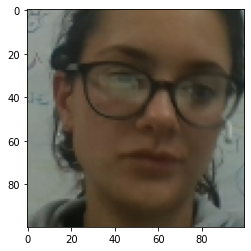

In [198]:
plt.imshow(samp[0])

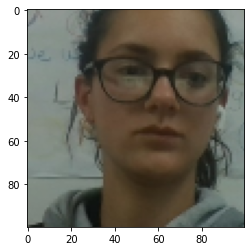

In [199]:
plt.imshow(samp[1])

In [200]:
samp[2]

1.0

In [112]:
round(len(data)*.7)

420

In [23]:
# Training partition
# grabbing 70% - which is 420 images for training partition
train_data = data.take(round(len(data)*.7))
# passing through data as batches of16 images
train_data = train_data.batch(16)
#starts preprocessing the next batch of images
train_data = train_data.prefetch(8)

In [24]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [25]:
# Testing partition
# skipped first 420 images
test_data = data.skip(round(len(data)*.7))
# passing through last 30% - 180 images
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [26]:
inp = Input(shape=(100,100,3), name='input_image')

In [27]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [28]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [29]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [30]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [31]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [32]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [34]:
def make_embedding(): 
    # defining our input - this is our input layer
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    # convolution is taking the number of filters that we want to pass through and our filter shape will be 10 pixels by 10 pixels.   
    # need to aply relu activation. Then passing input through convolution layer
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [42]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [36]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [37]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding, validation_embedding)

In [39]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [40]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [41]:
siamese_layer = L1Dist()

In [42]:
distances = siamese_layer(inp_embedding, val_embedding)

In [43]:
classifier = Dense(1, activation='sigmoid')(distances)

In [180]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_7')>

In [44]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [188]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [45]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [46]:
siamese_model = make_siamese_model()

In [190]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [47]:
# Cross-entropy loss refers to the contrast between two random variables; it measures them in order to extract the difference in the information they contain, showcasing the results. We use this type of loss function to calculate how accurate our machine learning or deep learning model is by defining the difference between the estimated probability with our desired outcome. 
# this type of loss function measures your model’s performance by transforming its variables into real numbers, thus, evaluating the “loss” that’s associated with them
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [48]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001 

In [49]:
# defined a directory where going to keep all our checkpoints
checkpoint_dir = './training_checkpoints'
# going to prefix all our checkpoints with ckpt - they'll all be in consistent format
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [50]:
test_batch = train_data.as_numpy_iterator()

In [51]:
batch_1 = test_batch.next()

In [52]:
# slicing first 2 values
X = batch_1[:2]

In [53]:
# all of our labels
y = batch_1[2]

In [221]:
y

array([1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [223]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

  **Recommended Usage:** (set `from_logits=True`)

  With `tf.keras` API:

  ```python
  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_log

In [54]:
# compiles a function into a callable TensorFlow graph.
@tf.function
def train_step(batch):
    
    # allows us to start capturing gradients from neural network model
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
         
        # Forward pass - making a prediction
        yhat = siamese_model(X, training=True)
        # Calculate loss - first pass through true y value, then y hat predicted value 
        loss = binary_cross_loss(y, yhat)
        
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [55]:
#An epoch means one complete pass of the training dataset through the algorithm.
def train(data, EPOCHS):
    # Loop through epochs
    # going to start at one, and then increpent epochs by one
    for epoch in range(1, EPOCHS+1):
        #going to tell us eg 2/100 - will give us status update
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        # generate progress bar
        progbar = tf.keras.utils.Progbar(len(data))
        
         # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            # update progress bar each time go through batch
            progbar.update(idx+1)
            
        # every 10 epochs, save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)      

In [56]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 1283s 47s/step

 Epoch 2/50
27/27 [==============================] - 1182s 44s/step

 Epoch 3/50
 4/27 [===>..........................] - ETA: 20:22

In [1]:
# Import metric calculations
# precision computes the precision of the predictions with respect to the labels.
# recall computes the recall of the predictions with respect to the labels.
from tensorflow.keras.metrics import Precision, Recall

In [57]:
# Get a batch of test data
# convert tenserflow dataset into numpy iterator.3 values - 16 inputs, then 16 pos/negs then labels.
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
# Make predictions - the ones with + on end are positive
y_hat = siamese_model.predict([test_input, test_val])
y_hat

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result - converting to numpy 
m.result().numpy()

In [ ]:
# Set plot size of pics underneath
plt.figure(figsize=(10,8))

# Set first subplot - since printing 2 images side by side so can have grid like format.
# only got one row at the bottom, 2 columns, and first image inside first one
plt.subplot(1,2,1)
# controllimg which image this is - if changed the 0 will be diff pic
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
# this index should be the same as one above, to show looking at same sample
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
# saving model weights - model weights are all the parameters of the model
siamese_model.save('siamesemodel.h5')

In [ ]:
# Reload model 
# passing through l1Dist, binarycrossentropy
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

In [ ]:
model.summary()

In [ ]:
# acces webcam using open cv. from webcam we will get our input image.
# use this input image and verify against a number of positive samples.
# images that will be in a folder and eg 50 images - we'll use them and loop through them. so one verification cyvle will be 50 predictions which increses our chance that we'll accurately verify that the person in the input image is in our positive class.
# our input image will be passed into the neural network as will the images in our positive class so if verified will be 1.
# verification threshhold - above a certain prob we will consider it positive. 
# then we will count the number of classes that surpass verification threshhold.the number that pass / number of images in class = detection metric.

In [ ]:
application_data\verification_images

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array - going to sotre all our results in a results array
    results = []
    # looping through every image inside verification images folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        # preprocess function for input image - read image, load image, rezise it and scale it.
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    # if verification is greater than threshhold will return true
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger - wen hit v will kick off verification loop
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()